In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATA_PATH = '../../Dataset/trdg'
FONT_PATH = '../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATA_PATH)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 2889
Number of labels found: 2889
Number of unique characters: 1697
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '仙': 139, '欺': 138, '群': 136, '𠳒': 136, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '別': 118, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '強': 102, '呐': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '冲': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '身': 87, '兜': 87, '𧡊': 86, '於': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '雲': 62, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '紅'

## Visualize the data

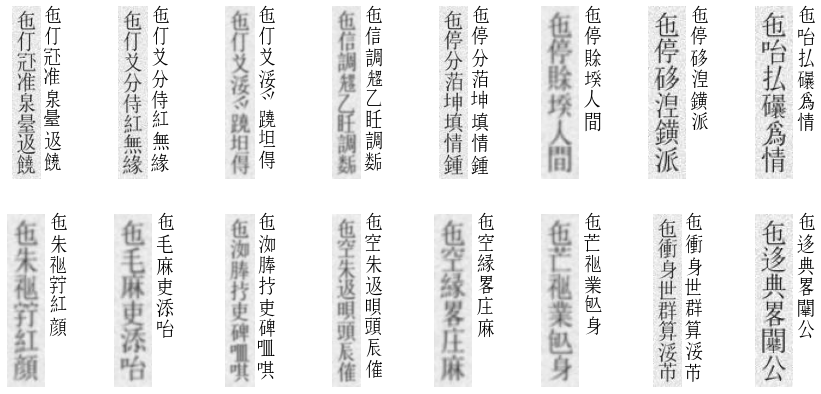

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
from ctc import CTCLayer
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn

# Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary()
# imagenet_output_layer = 'block3_pool'

In [10]:
def build_and_compile_model(name, imagenet_model=None, imagenet_output_layer=None):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_cnn(x, dim_to_keep=-1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    model.compile(optimizer=Adam(learning_rate=2e-4))
    return model

# Training

In [11]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Callbacks

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Data input pipeline

In [13]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [14]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Cross validation with K-Fold

In [15]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)
valid_datasets = []
best_epochs = []
edist_logs = []
histories = []
models = []

In [16]:
%%time
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(img_paths, labels)):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    valid_datasets.append((valid_tf_dataset, valid_idx))
    
    model = build_and_compile_model(f'Model_{fold_idx + 1}')
#     model = build_and_compile_model(
#         f'Model_{fold_idx + 1}', 
#         imagenet_model, # Use Imagenet model as CNN layers
#         imagenet_output_layer
#     )

    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH) 
    
    print(f'Start training for Fold {fold_idx + 1}:')
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = 100,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    print(f'Finish training for Fold {fold_idx + 1}\n')
    best_epochs.append(early_stopping_callback.best_epoch)
    edist_logs.append(edit_distance_callback.logs)
    histories.append(history)
    models.append(model)

Start training for Fold 1:
Epoch 1/100
163/163 [==============================] - 14s 47ms/step - loss: 51.4151 - val_loss: 50.9760 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 30ms/step - loss: 46.1575 - val_loss: 49.8372 - lr: 2.0000e-04
Epoch 3/100
163/163 [==============================] - 5s 30ms/step - loss: 38.2242 - val_loss: 37.2562 - lr: 2.0000e-04
Epoch 4/100
163/163 [==============================] - 5s 31ms/step - loss: 21.6824 - val_loss: 20.2460 - lr: 2.0000e-04
Epoch 5/100
163/163 [==============================] - 5s 30ms/step - loss: 11.3423 - val_loss: 11.5992 - lr: 2.0000e-04
Epoch 6/100
163/163 [==============================] - 5s 30ms/step - loss: 6.0583 - val_loss: 9.1657 - lr: 2.0000e-04
Epoch 7/100
163/163 [==============================] - 5s 31ms/step - loss: 3.2986 - val_loss: 6.7403 - lr: 2.0000e-04
Epoch 8/100
163/163 [==============================] - 5s 30ms/step - loss: 1.8639 - val_loss: 4.7801 - lr: 2.0000e-04
Epoch 9/10

163/163 [==============================] - 5s 31ms/step - loss: 41.1407 - val_loss: 42.7552 - lr: 2.0000e-04
Epoch 4/100
163/163 [==============================] - 5s 31ms/step - loss: 36.1590 - val_loss: 42.5541 - lr: 2.0000e-04
Epoch 5/100
163/163 [==============================] - 5s 31ms/step - loss: 30.5188 - val_loss: 39.3581 - lr: 2.0000e-04
Epoch 6/100
163/163 [==============================] - 5s 31ms/step - loss: 24.9576 - val_loss: 35.3481 - lr: 2.0000e-04
Epoch 7/100
163/163 [==============================] - 5s 31ms/step - loss: 19.9731 - val_loss: 36.9015 - lr: 2.0000e-04
Epoch 8/100
163/163 [==============================] - 5s 31ms/step - loss: 15.4586 - val_loss: 34.4687 - lr: 2.0000e-04
Epoch 9/100
163/163 [==============================] - 5s 31ms/step - loss: 11.8364 - val_loss: 30.9894 - lr: 2.0000e-04
Epoch 10/100
161/163 [============================>.] - ETA: 0s - loss: 8.7470 - Mean edit distance: 6.6513157
Restored weights from the end of epoch: 5
163/163 [===

 - Mean edit distance: 7.3092103
163/163 [==============================] - 5s 31ms/step - loss: 19.0668 - val_loss: 38.2384 - lr: 2.0000e-04
Epoch 8/100
163/163 [==============================] - 5s 31ms/step - loss: 14.3600 - val_loss: 28.8682 - lr: 1.0000e-04
Epoch 9/100
163/163 [==============================] - 5s 31ms/step - loss: 11.0213 - val_loss: 27.2420 - lr: 1.0000e-04
Epoch 10/100
162/163 [============================>.] - ETA: 0s - loss: 8.4717 - Mean edit distance: 6.0
Restored weights from the end of epoch: 5
163/163 [==============================] - 5s 31ms/step - loss: 8.4718 - val_loss: 26.9199 - lr: 1.0000e-04
Epoch 10: early stopping
Finish training for Fold 6

Start training for Fold 7:
Epoch 1/100
163/163 [==============================] - 11s 42ms/step - loss: 51.2455 - val_loss: 52.3075 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 30ms/step - loss: 45.2988 - val_loss: 47.8553 - lr: 2.0000e-04
Epoch 3/100
163/163 [=================

Epoch 35/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0174 - val_loss: 3.2573 - lr: 2.0000e-04
Epoch 36/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0161 - val_loss: 3.2027 - lr: 2.0000e-04
Epoch 37/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0148 - val_loss: 3.2143 - lr: 2.0000e-04
Epoch 38/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0138 - val_loss: 3.1965 - lr: 2.0000e-04
Epoch 39/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0129 - val_loss: 3.1972 - lr: 2.0000e-04
Epoch 40/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0120 - val_loss: 3.1740 - lr: 2.0000e-04
Epoch 41/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0114 - val_loss: 3.1256 - lr: 2.0000e-04
Epoch 42/100
163/163 [==============================] - 5s 31ms/step - loss: 2.3811 - val_loss: 27.6994 - lr: 2.0000e-04
Epoch 43/100
161/163 [=================

Epoch 27/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0249 - val_loss: 2.2998 - lr: 2.0000e-04
Epoch 28/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0227 - val_loss: 2.2638 - lr: 2.0000e-04
Epoch 29/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0208 - val_loss: 2.2706 - lr: 2.0000e-04
Epoch 30/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0190 - val_loss: 2.2438 - lr: 2.0000e-04
Epoch 31/100
163/163 [==============================] - 5s 31ms/step - loss: 0.0175 - val_loss: 2.2447 - lr: 2.0000e-04
Epoch 32/100
162/163 [============================>.] - ETA: 0s - loss: 0.0161
Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.6019737
163/163 [==============================] - 5s 31ms/step - loss: 0.0161 - val_loss: 2.2449 - lr: 2.0000e-04
Epoch 33/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0151 - val_loss: 2.2159 -

Epoch 8/100
163/163 [==============================] - 5s 31ms/step - loss: 14.7020 - val_loss: 32.8923 - lr: 2.0000e-04
Epoch 9/100
163/163 [==============================] - 5s 31ms/step - loss: 11.1201 - val_loss: 30.0890 - lr: 2.0000e-04
Epoch 10/100
161/163 [============================>.] - ETA: 0s - loss: 8.1240 - Mean edit distance: 6.0625
Restored weights from the end of epoch: 5
163/163 [==============================] - 5s 31ms/step - loss: 8.1246 - val_loss: 30.2521 - lr: 2.0000e-04
Epoch 10: early stopping
Finish training for Fold 9

Start training for Fold 10:
Epoch 1/100
163/163 [==============================] - 12s 47ms/step - loss: 50.9327 - val_loss: 53.4643 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 30ms/step - loss: 45.3531 - val_loss: 48.2013 - lr: 2.0000e-04
Epoch 3/100
163/163 [==============================] - 5s 31ms/step - loss: 41.5102 - val_loss: 44.9030 - lr: 2.0000e-04
Epoch 4/100
163/163 [==============================] - 

## Get the best CRNN model and its results

In [26]:
best_loss = float('inf')
for fold_idx, model in enumerate(models):
    final_edist = edist_logs[fold_idx][best_epochs[fold_idx]]
    print(f'Fold {fold_idx + 1:02d} - Mean edit distance: {final_edist}')
    final_val_loss = model.evaluate(valid_datasets[fold_idx][0], verbose=1)
    if final_val_loss < best_loss:
        best_loss = final_val_loss
        best_fold_idx = fold_idx

Fold 01 - Mean edit distance: 1.4276316165924072
19/19 [==============================] - 0s 13ms/step - loss: 2.1651
Fold 02 - Mean edit distance: 7.1052632331848145
19/19 [==============================] - 0s 13ms/step - loss: 34.9611
Fold 03 - Mean edit distance: 7.648026466369629
19/19 [==============================] - 0s 13ms/step - loss: 39.3581
Fold 04 - Mean edit distance: 7.148026466369629
19/19 [==============================] - 0s 13ms/step - loss: 30.6022
Fold 05 - Mean edit distance: 7.470394611358643
19/19 [==============================] - 0s 13ms/step - loss: 38.7151
Fold 06 - Mean edit distance: 7.279605388641357
19/19 [==============================] - 0s 13ms/step - loss: 36.7678
Fold 07 - Mean edit distance: 1.4473683834075928
19/19 [==============================] - 0s 12ms/step - loss: 2.4881
Fold 08 - Mean edit distance: 1.605263113975525
19/19 [==============================] - 0s 13ms/step - loss: 2.1603
Fold 09 - Mean edit distance: 7.217105388641357
19/19 [=

In [27]:
best_model = models[best_fold_idx]
best_model.save('crnn_trdg.h5')
best_model.summary()

Model: "Model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 block1_bn1 (BatchNormalization  (None, 148, 32, 64)  256        ['block1_conv1[0][0]']           
 )                                                                                                
                                                                                            

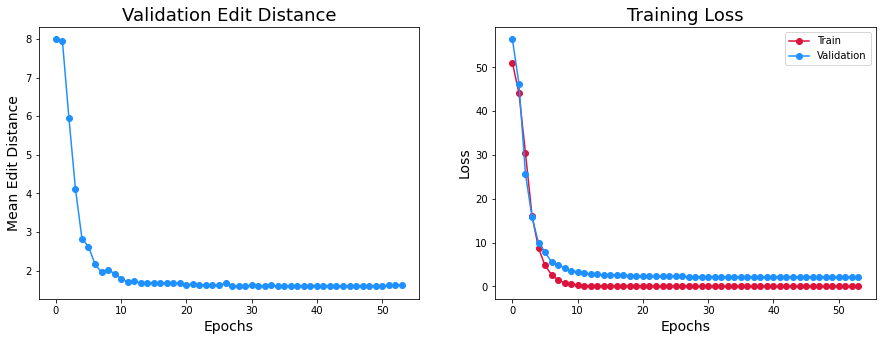

In [28]:
from visualizer import plot_training_results
plot_training_results(
    histories[best_fold_idx], 
    edist_logs[best_fold_idx], 
    save_name = 'crnn_trdg_history.png'
)

# Inference

In [29]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions
best_valid_dataset = valid_datasets[best_fold_idx][0]
best_valid_idxs = valid_datasets[best_fold_idx][1]

## Reload the model

In [30]:
reloaded_model = load_model('crnn_trdg.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_8"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

In [48]:
from importlib import reload
import visualizer
reload(visualizer)
from visualizer import visualize_images_labels

Batch 1: ['㐌停𥒥\U000f07ba鐄派', '㐌空朱﨤𣇜頭辰傕', '㗂嬌同望䏾襜𢠩恾', '㗂寃㐌悶拍𡗶呌𨖲', '㝵𠸗縸案苔𠫾', '㝵𡢐別固﨤堆庒\U000f047c', '㤕娘群拙双親', '䀡耒吏遣𢚸恒㤕車', '䜹浪碎分女兒', '䜹茹萱歇每情', '不情浽陣𩄲湄', '主東𦋦塊園春', '丿\U000f0993𠫾﨤信茄\U000f0742书', '云仙䜹訴每塘𧵆賖', '交朱囯状默筭法刑', '仍𢜠特准安身']

Batch 2: ['仍\U000f047c煩悶𣎀𣈜', '仙浪各注迻些', '仙浪拠事爫牢', '仙浪翁舘渚唭', '会尼\U000f0778及群除会芇', '信春兜易𠫾𧗱朱能', '倍傍𦲿用花淶', '催催妾㐌負払自低', '傷台身分落類', '傷\U000f047c傷\U000f124e圣人', '六公欺𧘇買信事情', '六翁渃𬑉𣻆淶', '共𥪞\U000f070b㗂絲同', '其心户束拱𣳔書香', '其饒交𥛉\U000f070b茹', '判浪朕𢜝渃畨']



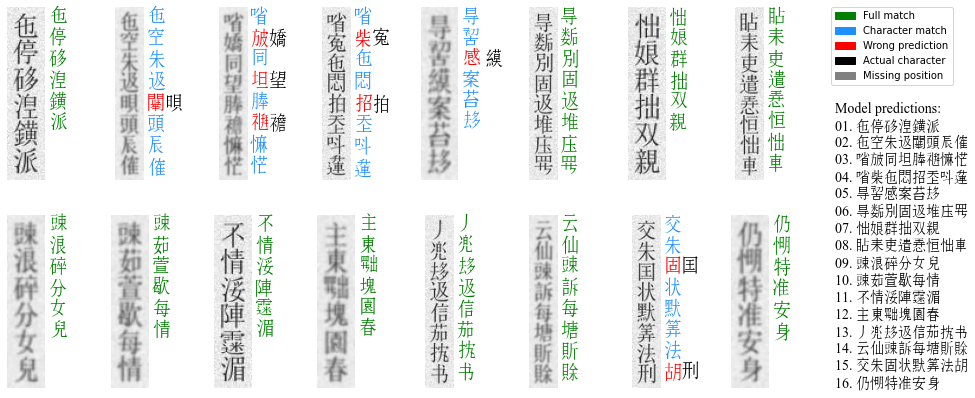

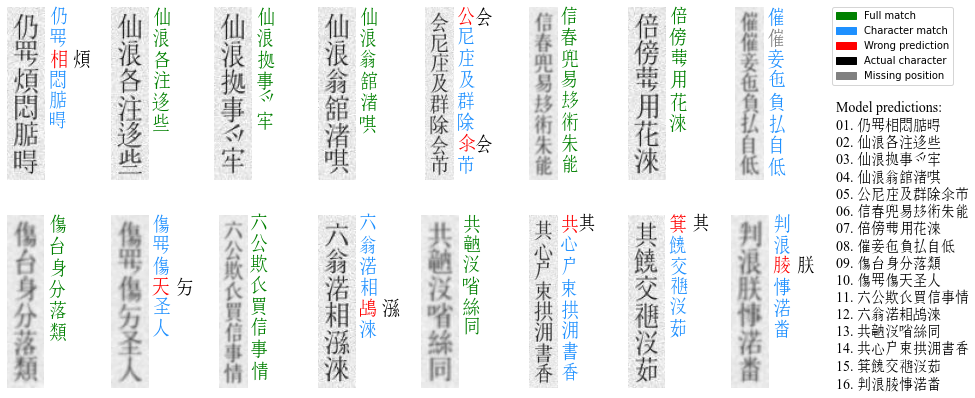

In [49]:
for idx, batch in enumerate(best_valid_dataset.take(2)):
    batch_images, batch_labels = batch['image'], batch['label']
    valid_idxs = best_valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    valid_labels = []
    
    for label in batch_labels:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        valid_labels.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch_images)
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[valid_idxs], 
        labels = valid_labels, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {valid_labels}\n')

## On random image

In [50]:
random_image = process_images_labels('../大越史記全書.jpg', '大越史記全書')
batch_images = tf.expand_dims(random_image['image'], axis=0)
batch_labels = tf.expand_dims(random_image['label'], axis=0)

Predicted text: 大越史記玉書


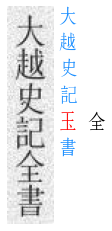

In [51]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))